<a href="https://colab.research.google.com/github/Nikhil4002-50-82/Emotion-Detection/blob/main/Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

In [124]:
from google.colab import files
import cv2

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving happy.jpg to happy (4).jpg


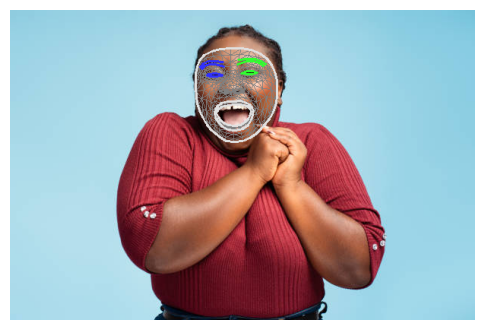

In [125]:
import mediapipe as mp
import matplotlib.pyplot as plt
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
) as face_mesh:
    results = face_mesh.process(rgb_image)
    annotated_image = rgb_image.copy()
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
            )
            mp_drawing.draw_landmarks(
                image=annotated_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
            )
plt.figure(figsize=(6,6))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()


In [126]:
import numpy as np

if results.multi_face_landmarks:
    face_landmarks = results.multi_face_landmarks[0]
    h, w, _ = rgb_image.shape
    landmark_points = np.array([(int(l.x * w), int(l.y * h), l.z) for l in face_landmarks.landmark])
    print("Number of landmarks detected:", len(landmark_points))
    print("Sample (first 5):")
    print(landmark_points[:5])

Number of landmarks detected: 478
Sample (first 5):
[[ 2.94000000e+02  1.20000000e+02 -3.11935917e-02]
 [ 2.89000000e+02  1.04000000e+02 -4.55220677e-02]
 [ 2.91000000e+02  1.10000000e+02 -2.89906729e-02]
 [ 2.85000000e+02  9.10000000e+01 -2.82263681e-02]
 [ 2.89000000e+02  9.90000000e+01 -4.63412702e-02]]


In [127]:
landmarks = np.array([(l.x, l.y, l.z) for l in face_landmarks.landmark], dtype=np.float32)

In [128]:
import numpy as np

def euclidean(p1, p2):
    return np.linalg.norm(p1 - p2)

def extract_features(landmarks):
    # Convert to NumPy for easier math
    landmarks = np.array(landmarks)

    # ---- Mouth ----
    mouth_left = landmarks[61, :2]
    mouth_right = landmarks[291, :2]
    mouth_top = landmarks[13, :2]
    mouth_bottom = landmarks[14, :2]
    mouth_width = euclidean(mouth_left, mouth_right)
    mouth_height = euclidean(mouth_top, mouth_bottom)
    mouth_aspect_ratio = mouth_height / (mouth_width + 1e-6)

    # ---- Eyes ----
    left_eye_top = landmarks[159, :2]
    left_eye_bottom = landmarks[145, :2]
    right_eye_top = landmarks[386, :2]
    right_eye_bottom = landmarks[374, :2]
    left_eye_height = euclidean(left_eye_top, left_eye_bottom)
    right_eye_height = euclidean(right_eye_top, right_eye_bottom)
    eye_openness = (left_eye_height + right_eye_height) / 2

    # Eye width
    left_eye_outer = landmarks[33, :2]
    left_eye_inner = landmarks[133, :2]
    right_eye_inner = landmarks[362, :2]
    right_eye_outer = landmarks[263, :2]
    left_eye_width = euclidean(left_eye_outer, left_eye_inner)
    right_eye_width = euclidean(right_eye_inner, right_eye_outer)
    eye_aspect_ratio = (eye_openness) / ((left_eye_width + right_eye_width)/2 + 1e-6)

    # ---- Eyebrows ----
    left_eyebrow_outer = landmarks[70, :2]
    left_eyebrow_inner = landmarks[55, :2]
    right_eyebrow_inner = landmarks[285, :2]
    right_eyebrow_outer = landmarks[300, :2]
    eyebrow_raise_left = euclidean(left_eyebrow_outer, left_eye_top)
    eyebrow_raise_right = euclidean(right_eyebrow_outer, right_eye_top)
    eyebrow_slant_left = euclidean(left_eyebrow_outer, left_eyebrow_inner)
    eyebrow_slant_right = euclidean(right_eyebrow_inner, right_eyebrow_outer)

    # ---- Nose & Face ----
    nose_tip = landmarks[1, :2]
    chin = landmarks[152, :2]
    nose_base = landmarks[168, :2]
    jaw_drop = euclidean(chin, nose_base)

    nose_mouth_dist = euclidean(nose_tip, (mouth_top + mouth_bottom)/2)

    # ---- Symmetry ----
    mouth_corner_diff = abs(mouth_left[1] - mouth_right[1])  # height difference

    # ---- Aggregate ----
    features = np.array([
        mouth_width, mouth_height, mouth_aspect_ratio,
        left_eye_height, right_eye_height, eye_openness, eye_aspect_ratio,
        eyebrow_raise_left, eyebrow_raise_right,
        eyebrow_slant_left, eyebrow_slant_right,
        jaw_drop, nose_mouth_dist, mouth_corner_diff
    ], dtype=np.float32)
    face_scale = euclidean(landmarks[33, :2], landmarks[263, :2])
    features /= (face_scale + 1e-6)

    return features

In [112]:
from google.colab import files
import os

print("Upload your kaggle.json file.")
uploaded = files.upload()

# Check and move kaggle.json to the correct place
if "kaggle.json" in uploaded:
    os.makedirs("/root/.kaggle", exist_ok=True)
    with open("/root/.kaggle/kaggle.json", "wb") as f:
        f.write(uploaded["kaggle.json"])
    os.chmod("/root/.kaggle/kaggle.json", 600)
    print("Kaggle API is set up successfully.")
else:
    print("kaggle.json not uploaded. Please try again.")

Upload your kaggle.json file.


Saving kaggle.json to kaggle (4).json
kaggle.json not uploaded. Please try again.


In [39]:
!pip install kaggle

In [113]:
import os
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

dataset_name = "shuvoalok/ck-dataset"
extract_path = "/content/ckplus_data"
print("Downloading CK+ dataset from Kaggle...")

api = KaggleApi()
api.authenticate()
api.dataset_download_files(dataset_name, path=extract_path, unzip=False)

zip_files = [f for f in os.listdir(extract_path) if f.endswith(".zip")]
if not zip_files:
    raise FileNotFoundError("No zip file found. Check the dataset name.")
zip_path = os.path.join(extract_path, zip_files[0])
print(f"Extracting {zip_files[0]} ...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

os.remove(zip_path)

print(f"Dataset extracted to: {extract_path}\n")

print("📂 Folder structure:\n")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}📁 {os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}- {f}")

Dataset URL: https://www.kaggle.com/datasets/shuvoalok/ck-dataset
Extracting ck-dataset.zip ...
Dataset extracted to: /content/ckplus_data

📂 Folder structure:

📁 ckplus_data/
    📁 happy/
        - S011_006_00000012.png
        - S129_012_00000011.png
        - S095_007_00000021.png
        - S083_003_00000018.png
        - S010_006_00000014.png
    📁 surprise/
        - S050_002_00000017.png
        - S126_004_00000012.png
        - S011_001_00000016.png
        - S122_001_00000012.png
        - S079_001_00000011.png
    📁 anger/
        - S028_001_00000022.png
        - S090_007_00000013.png
        - S026_003_00000015.png
        - S082_005_00000017.png
        - S111_006_00000008.png
    📁 contempt/
        - S139_002_00000013.png
        - S149_002_00000013.png
        - S151_002_00000028.png
        - S155_002_00000012.png
        - S160_006_00000010.png
    📁 disgust/
        - S111_007_00000013.png
        - S081_008_00000009.png
        - S125_008_00000008.png
        - S125_

In [114]:
import pandas as pd
from tqdm import tqdm

mp_face_mesh = mp.solutions.face_mesh
data_dir = "/content/ckplus_data"
data = []

emotion_labels = ["happy", "surprise", "anger", "contempt", "disgust", "sadness", "fear"]

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
) as face_mesh:

    for emotion in emotion_labels:
        folder_path = os.path.join(data_dir, emotion)
        if not os.path.exists(folder_path):
            print(f"⚠️ Folder not found: {folder_path}")
            continue

        print(f"\nProcessing emotion: {emotion}")
        for file in tqdm(os.listdir(folder_path)):
            if not (file.endswith(".png") or file.endswith(".jpg")):
                continue

            img_path = os.path.join(folder_path, file)
            image = cv2.imread(img_path)
            if image is None:
                continue

            rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(rgb)

            if results.multi_face_landmarks:
                landmarks = np.array(
                    [[lm.x, lm.y, lm.z] for lm in results.multi_face_landmarks[0].landmark],
                    dtype=np.float32
                )
                features = extract_features(landmarks)
                data.append(np.append(features, emotion))
            else:
                print(f"No face detected in: {file}")

feature_names = [
    "mouth_width", "mouth_height", "mouth_aspect_ratio",
    "left_eye_height", "right_eye_height", "eye_openness", "eye_aspect_ratio",
    "eyebrow_raise_left", "eyebrow_raise_right",
    "eyebrow_slant_left", "eyebrow_slant_right",
    "jaw_drop", "nose_mouth_dist", "mouth_corner_diff", "label"
]

df = pd.DataFrame(data, columns=feature_names)
output_csv = "/content/features.csv"
df.to_csv(output_csv, index=False)

print(f"\nFeature extraction complete!")
print(f"Saved CSV to: {output_csv}")
print(f"Total samples extracted: {len(df)}")


Processing emotion: happy


100%|██████████| 207/207 [00:01<00:00, 109.11it/s]



Processing emotion: surprise


100%|██████████| 249/249 [00:02<00:00, 108.92it/s]



Processing emotion: anger


100%|██████████| 135/135 [00:01<00:00, 92.49it/s]



Processing emotion: contempt


100%|██████████| 54/54 [00:00<00:00, 70.34it/s]



Processing emotion: disgust


100%|██████████| 177/177 [00:01<00:00, 89.82it/s] 



Processing emotion: sadness


100%|██████████| 84/84 [00:00<00:00, 112.50it/s]



Processing emotion: fear


100%|██████████| 75/75 [00:00<00:00, 115.39it/s]


Feature extraction complete!
Saved CSV to: /content/features.csv
Total samples extracted: 981


CSV loaded successfully!
Total samples: 981

Columns in the dataset:
['mouth_width', 'mouth_height', 'mouth_aspect_ratio', 'left_eye_height', 'right_eye_height', 'eye_openness', 'eye_aspect_ratio', 'eyebrow_raise_left', 'eyebrow_raise_right', 'eyebrow_slant_left', 'eyebrow_slant_right', 'jaw_drop', 'nose_mouth_dist', 'mouth_corner_diff', 'label']

First few rows:


,mouth_width,mouth_height,mouth_aspect_ratio,left_eye_height,right_eye_height,eye_openness,eye_aspect_ratio,eyebrow_raise_left,eyebrow_raise_right,eyebrow_slant_left,eyebrow_slant_right,jaw_drop,nose_mouth_dist,mouth_corner_diff,label
0,0.773508,0.143190,0.352841,0.043137,0.040493,0.041815,0.268312,0.283427,0.277396,0.512866,0.495533,1.236371,0.290281,0.017542,happy
1,0.708940,0.023853,0.066409,0.071178,0.075872,0.073525,0.489912,0.306567,0.305512,0.509536,0.502282,1.246390,0.220743,0.018947,happy
2,0.670777,0.119117,0.348699,0.047472,0.047438,0.047455,0.321656,0.296244,0.285992,0.510336,0.488702,1.312085,0.355013,0.063759,happy
3,0.738212,0.140127,0.340294,0.052694,0.070657,0.061676,0.378118,0.306705,0.287413,0.491522,0.444318,1.170816,0.261696,0.013491,happy
4,0.712511,0.165436,0.431187,0.079910,0.083463,0.081686,0.494444,0.253440,0.279670,0.462946,0.497973,1.229312,0.296816,0.031036,happy



Label distribution:
label
surprise    249
happy       207
disgust     177
anger       135
sadness      84
fear         75
contempt     54
Name: count, dtype: int64


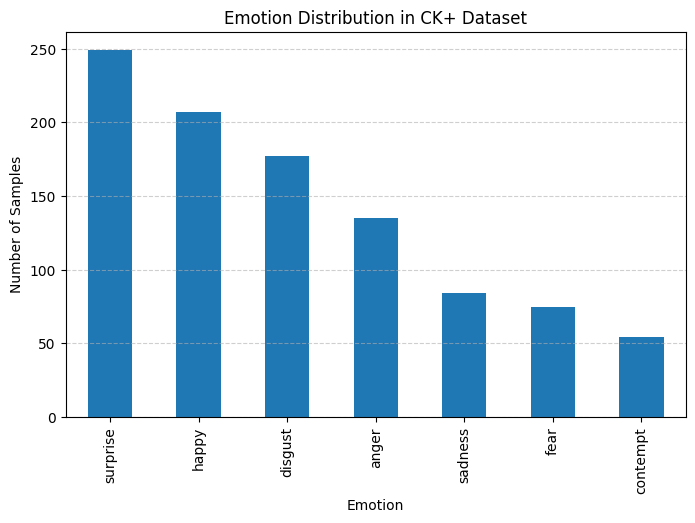

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/features.csv")

print("CSV loaded successfully!")
print(f"Total samples: {len(df)}")
print("\nColumns in the dataset:")
print(df.columns.tolist())

print("\nFirst few rows:")
display(df.head())

label_counts = df['label'].value_counts()

print("\nLabel distribution:")
print(label_counts)

plt.figure(figsize=(8,5))
label_counts.plot(kind='bar')
plt.title("Emotion Distribution in CK+ Dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

Class weights: {0: 1.0380952380952382, 1: 2.5952380952380953, 2: 0.7917675544794189, 3: 1.8685714285714285, 4: 0.6770186335403726, 5: 1.6683673469387754, 6: 0.5628227194492255}
Classes: ['anger' 'contempt' 'disgust' 'fear' 'happy' 'sadness' 'surprise']
Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.3010 - loss: 1.8496 - val_accuracy: 0.5605 - val_loss: 1.3898
Epoch 2/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5264 - loss: 1.5208 - val_accuracy: 0.6752 - val_loss: 1.1022
Epoch 3/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6014 - loss: 1.3160 - val_accuracy: 0.7389 - val_loss: 0.9309
Epoch 4/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6566 - loss: 1.1998 - val_accuracy: 0.7516 - val_loss: 0.8240
Epoch 5/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6853 - loss: 1.0867 - val_accuracy: 0.7452 - val_loss: 0.7516
Epoch 6/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6796 - loss: 1.0312 - val_accuracy: 0.7452 - val_loss: 0.6958
Epoch 7/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6948 - loss: 0.9044 - val_accuracy: 0.7898 - val_loss: 0.6497
Epoch 8/60
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7346 - loss: 0.8541 - val_accuracy: 0.7962 - val_loss: 0.6222
Ep

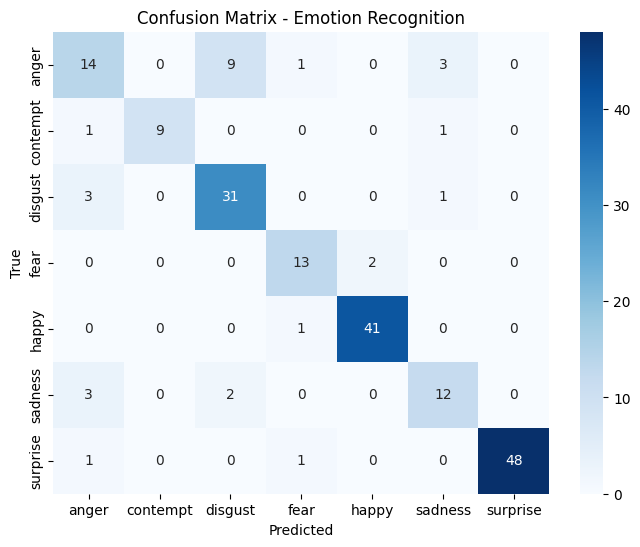


Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.52      0.57        27
    contempt       1.00      0.82      0.90        11
     disgust       0.74      0.89      0.81        35
        fear       0.81      0.87      0.84        15
       happy       0.95      0.98      0.96        42
     sadness       0.71      0.71      0.71        17
    surprise       1.00      0.96      0.98        50

    accuracy                           0.85       197
   macro avg       0.84      0.82      0.82       197
weighted avg       0.85      0.85      0.85       197



In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/features.csv")

X = df.drop(columns=['label']).values
y = df['label'].values

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
num_classes = len(encoder.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)
print("Classes:", encoder.classes_)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=16,
    class_weight=class_weights,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

y_pred = np.argmax(model.predict(X_test), axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Emotion Recognition")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


In [129]:
model.save("emotion_model.h5")
print("Model saved successfully as emotion_model.h5")

Model saved successfully as emotion_model.h5


In [130]:
import joblib

joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "label_encoder.pkl")
print("Saved scaler and label encoder.")

Saved scaler and label encoder.


In [131]:
from tensorflow.keras.models import load_model

model = load_model("emotion_model.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [143]:
# features = extract_features(landmarks)
# features = features.reshape(1, -1)

# pred = model.predict(features)

# emotion_labels = ["surprise", "happy", "disgust", "anger", "sadness", "fear", "contempt"]
# predicted_label = emotion_labels[np.argmax(pred)]

# print("Predicted Emotion:", predicted_label)

from tensorflow.keras.models import load_model
import joblib
import numpy as np

model = load_model("emotion_model.h5")
scaler = joblib.load("scaler.pkl")
encoder = joblib.load("label_encoder.pkl")

features = extract_features(landmarks)
features = features.reshape(1, -1)
features_scaled = scaler.transform(features)

pred = model.predict(features_scaled)
predicted_class_index = np.argmax(pred)
predicted_label = encoder.inverse_transform([predicted_class_index])[0]

print("Predicted Emotion:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Emotion: surprise


In [144]:
emotion_emojis = {
    "surprise": "😮",
    "happy": "😄",
    "disgust": "🤢",
    "anger": "😠",
    "sadness": "😢",
    "fear": "😨",
    "contempt": "😒"
}

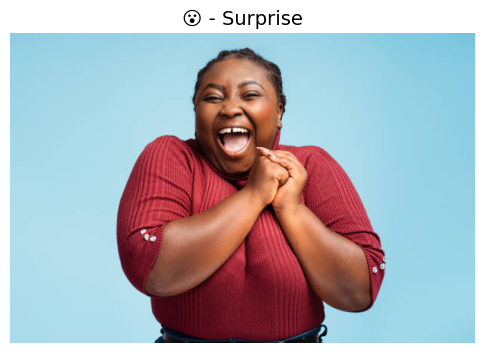

In [145]:
emoji_icon = emotion_emojis.get(predicted_label, "😐")
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"{emoji_icon} - {predicted_label.capitalize()}", fontsize=14)
plt.axis("off")
plt.show()